# Analyze docking and molecular dynamics results and generate figure plots

## Imports and Constants

In [126]:
import os
import warnings
from collections import defaultdict
from glob import glob
import biotite.structure as struc
import biotite.structure.io as strucio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
import numpy as np

sns.set_context("paper")

In [127]:
# List of proteins
PROTEINS = [
    "anc451",
    "anc452",
    "anc454",
    "caze",
]

# Protein segname
PROT_SEGNAME = "PROA"

# 5CThioester resname and segname
C5_RESNAME = "5CT"
C5_SEGNAME = "5CT1"

# Ancestor substrate resname and segname
ANC_RESNAME = "ANC"
ANC_SEGNAME = "ANC1"

In [128]:
# List of histidine 172 numbering
HISTIDINE_172_RESIS = {
    "anc451": 166,
    "anc452": 169,
    "anc454": 166,
    "caze": 172,
}

# Histidine 172 nitrogen
HISTIDINE_172_NITROGEN = "NE2"

# Ligand Oxygen
LIGAND_OXYGEN = "O2"

# 5CThioester carboynl
C5_CARBONYL_CARBON = "C12"
C5_CARBONYL_OXYGEN = "O8"

## Docking Analysis

In [129]:
def get_top_cluster_poses(dockresult_dir):
    """Retrieve the top clustered ligand poses from the docking result directory."""

    # Check whether the results are for rigid docking or flexible docking
    rcdocker_cluster_dir = os.path.join(dockresult_dir, "cluster")
    fcdocker_cluster_dir = os.path.join(dockresult_dir, "cluster/ligand")
    cluster_dir = fcdocker_cluster_dir
    if not os.path.exists(cluster_dir):
        cluster_dir = rcdocker_cluster_dir

    # Get the top cluster poses
    poses = glob(f"{cluster_dir}/top_*.pdb")
    poses = sorted(poses, key=lambda x: int(x.split("_")[-1].split(".")[0]))

    return poses

In [130]:
# Retrieve receptor structures used for docking
dock_receptors = [
    f"../add_5cthioester/5cthioester/{protein}_5cthioester.pdb" for protein in PROTEINS
]

# List of docking strategies
strategies = ["rcdocker", "fcdocker", "fcdocker_flexible_5cthioester"]

# Retrieve ligand poses for each docking strategy
dock_poses = defaultdict(dict)

for strategy in strategies:
    strategy_dir = f"../{strategy}/{strategy}_results"
    for protein in PROTEINS:
        dockresult_dir = (
            f"{strategy_dir}/{protein}_5cthioester_anc_substrate/dockresult"
        )
        dock_poses[strategy][protein] = get_top_cluster_poses(dockresult_dir)

In [131]:
# Get distance between ligand oxygen and carboynl carbon for each docking pose
def get_ligand_carbonyl_dist(
    receptor_pdb,
    ligand_pdb,
):

    # Read structure with biotite
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        receptor_structure = strucio.load_structure(receptor_pdb)
        ligand_structure = strucio.load_structure(ligand_pdb)

    # Get structure of ligand oxygen
    ligand_oxygen_structure = ligand_structure[
        ligand_structure.atom_name == LIGAND_OXYGEN
    ]

    # Get structure of prosthetic group carbonyl carbon
    c5_carbon_structure = receptor_structure[
        (receptor_structure.atom_name == C5_CARBONYL_CARBON)
        & (receptor_structure.res_name == C5_RESNAME)
    ]

    # Get distance between ligand oxygen and carboynl carbon
    carbonyl_oxy_dist = struc.distance(
        ligand_oxygen_structure,
        c5_carbon_structure,
    )

    return carbonyl_oxy_dist[0]


# Build a dataframe with the distance between ligand oxygen and carboynl carbon for each docking pose, protein, and docking strategy
dock_data = []
for strategy in strategies:
    for protein in PROTEINS:
        for pose in dock_poses[strategy][protein]:
            carbonyl_oxy_dist = get_ligand_carbonyl_dist(
                dock_receptors[PROTEINS.index(protein)],
                pose,
            )
            dock_data.append(
                {
                    "strategy": strategy,
                    "protein": protein,
                    "pose": pose,
                    "carbonyl_oxy_dist": carbonyl_oxy_dist,
                }
            )

dock_df = pd.DataFrame(dock_data)
dock_df

,strategy,protein,pose,carbonyl_oxy_dist
0,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,8.923352
1,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,7.545372
2,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,8.268691
3,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,11.104248
4,rcdocker,anc451,../rcdocker/rcdocker_results/anc451_5cthioeste...,10.483904
...,...,...,...,...
153,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.268963
154,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.038149
155,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,8.730351
156,fcdocker_flexible_5cthioester,caze,../fcdocker_flexible_5cthioester/fcdocker_flex...,10.265694


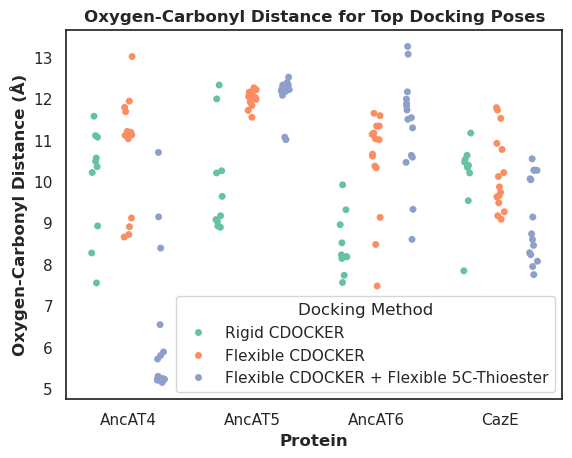

In [132]:
# Create figure plot

# Rename docking methods
plot_df = dock_df.copy()
plot_df["strategy"] = plot_df["strategy"].replace(
    {
        "rcdocker": "Rigid CDOCKER",
        "fcdocker": "Flexible CDOCKER",
        "fcdocker_flexible_5cthioester": "Flexible CDOCKER + Flexible 5C-Thioester",
    }
)

# Rename proteins
plot_df["protein"] = plot_df["protein"].replace(
    {
        "anc451": "AncAT4",
        "anc452": "AncAT5",
        "anc454": "AncAT6",
        "caze": "CazE",
    }
)


sns.set(font_scale=1)
sns.set_style("white")
sns.stripplot(
    data=plot_df,
    x="protein",
    y="carbonyl_oxy_dist",
    hue="strategy",
    dodge=True,
    alpha=1,
    jitter=True,
    palette="Set2",
)

plt.xlabel("Protein", weight="bold")
plt.ylabel("Oxygen-Carbonyl Distance (Å)", weight="bold")
plt.title("Oxygen-Carbonyl Distance for Top Docking Poses", weight="bold")
plt.legend(title="Docking Method", loc="lower right")
plt.savefig("oxygen_carbonyl_distance.png", dpi=300, bbox_inches="tight")

## Dynamics Analysis

In [133]:
# Directory with dynamics results
dyn_dir = "../dyn/dyn"

# Directory with psf files
psf_dir = "../dyn/solvate/solvated_structures"

# Get all universe objects for each protein
universes = {}
for protein in PROTEINS:
    psf_file = f"{psf_dir}/{protein}_5cthioester_anc_substrate.psf"
    dcd_file = f"{dyn_dir}/{protein}_5cthioester_anc_substrate/dyn.dcd"
    universes[protein] = mda.Universe(psf_file, dcd_file)

/home/azamh/miniconda3/envs/acyl/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [134]:
# Compute nucleophilic attack angle and distance
def compute_nuc(protein, u: mda.Universe):
    def angle_between_two_vecs(x, y):
        """Compute angle between two vectors"""
        return np.arccos(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

    def angle_between_two_planes(x, y):
        """Compute angle between two planes defined by normal vectors"""
        return np.arccos(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))

    # Define selections

    # Ligand oxygen
    lig_sel = f"resname {ANC_RESNAME} and name {LIGAND_OXYGEN}"
    lig_atom = u.select_atoms(lig_sel, updating=True)

    # 5CThioester carbonyl carbon
    c5_sel = f"resname {C5_RESNAME} and name {C5_CARBONYL_CARBON}"
    c5_atom = u.select_atoms(c5_sel, updating=True)

    # 5CThioester carbonyl oxygen
    c5_oxy_sel = f"resname {C5_RESNAME} and name {C5_CARBONYL_OXYGEN}"
    c5_oxy_atom = u.select_atoms(c5_oxy_sel, updating=True)

    # Histidine 172 nitrogen
    his_sel = f"resid {HISTIDINE_172_RESIS[protein]} and name {HISTIDINE_172_NITROGEN}"
    his_atom = u.select_atoms(his_sel, updating=True)

    # Store measurements
    measurements = {}

    # Loop over frames
    for frame, ts in enumerate(u.trajectory):

        # Store positions for carbonyl carbon (C), carbonyl oxygen (O), and nucleophile (N)
        C = c5_atom.positions[0]
        O = c5_oxy_atom.positions[0]
        N = lig_atom.positions[0]
        H = his_atom.positions[0]

        CO_vector = C - O
        NC_vector = N - C

        # Compute Bürgi–Dunitz angle
        bd_angle = angle_between_two_vecs(NC_vector, CO_vector)

        # Compute distance between nucleophile and carbonyl carbon
        nuc_carb_dist = np.linalg.norm(N - C)

        # Compute distance between nucleophile and histidine 172 nitrogen
        nuc_his_dist = np.linalg.norm(N - H)

        # Store measurements
        measurements[frame] = {
            "bd_angle": np.degrees(bd_angle),
            "nuc_carb_dist": nuc_carb_dist,
            "nuc_his_dist": nuc_his_dist,
            "Protein": protein,
        }

    # Convert to dataframe
    df = pd.DataFrame(measurements).T

    return df


# Compute nucleophilic attack angle and distance for each protein
nuc_dfs = [compute_nuc(protein, u) for protein, u in universes.items()]
nuc_df = pd.concat(nuc_dfs)
nuc_df

,bd_angle,nuc_carb_dist,nuc_his_dist,Protein
0,128.212372,6.371756,5.312216,anc451
1,129.741943,6.250637,5.815598,anc451
2,125.870834,6.867115,5.371814,anc451
3,120.398224,6.410408,5.784691,anc451
4,132.404922,6.152549,5.37697,anc451
...,...,...,...,...
495,141.0215,9.055449,4.689445,caze
496,146.59967,8.994858,4.679032,caze
497,124.491119,9.106721,4.414865,caze
498,133.810654,9.077816,4.450055,caze


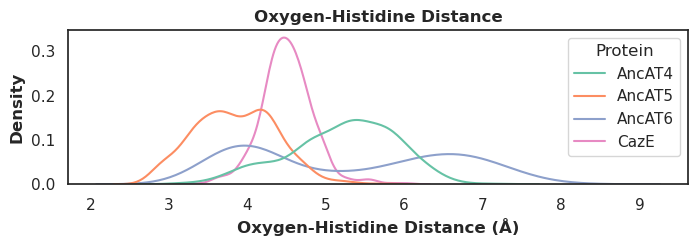

In [135]:
# Plot dynamics results
plot_df = nuc_df.copy()

# Rename proteins
plot_df["Protein"] = plot_df["Protein"].replace(
    {
        "anc451": "AncAT4",
        "anc452": "AncAT5",
        "anc454": "AncAT6",
        "caze": "CazE",
    }
)


# Plot histogram of nucleophile histidine distance
sns.set(font_scale=1)
sns.set_style("white")
plt.figure(figsize=(8, 2))
sns.kdeplot(
    data=plot_df,
    x="nuc_his_dist",
    hue="Protein",
    palette="Set2",
)
plt.xlabel("Oxygen-Histidine Distance (Å)", weight="bold")
plt.ylabel("Density", weight="bold")
plt.title("Oxygen-Histidine Distance", weight="bold")
# plt.legend(title="Protein", loc="upper right")
plt.savefig("oxygen_histidine_distance.png", dpi=300, bbox_inches="tight")

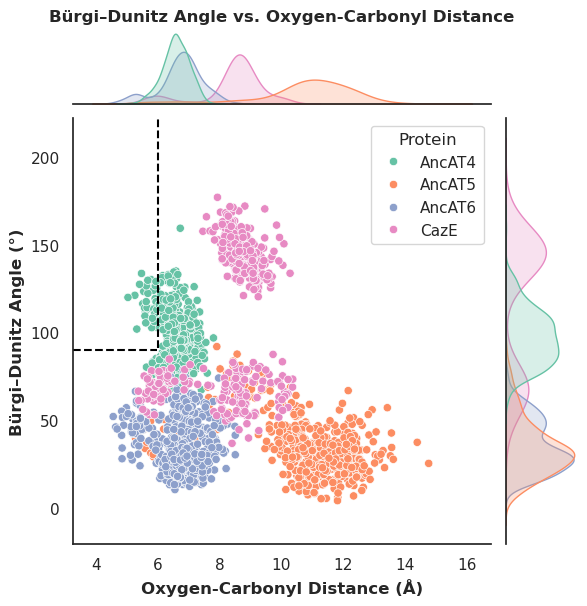

In [137]:
# Plot joint plot of bd_angle and nuc_carb_dist
sns.set(font_scale=1)
sns.set_style("white")
sns.jointplot(
    data=plot_df,
    x="nuc_carb_dist",
    y="bd_angle",
    hue="Protein",
    palette="Set2",
)

# Add dashed lines for cutoffs
plt.axhline(90, color="black", linestyle="--", xmax=0.2)
plt.axvline(6, color="black", linestyle="--", ymin=0.46)
plt.xlabel("Oxygen-Carbonyl Distance (Å)", weight="bold")
plt.ylabel("Bürgi–Dunitz Angle (°)", weight="bold")
plt.title("Bürgi–Dunitz Angle vs. Oxygen-Carbonyl Distance", weight="bold", pad=70)
plt.legend(title="Protein", loc="upper right")
plt.savefig("nucleophilic_attack.png", dpi=300, bbox_inches="tight")